#### Imports, file loading, and function definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 300 

In [3]:
fileName = 'PLL Stats Master - Player Game Logs.csv'
playerdata = pd.read_csv(fileName)
playerdata = playerdata[0:3770]

fileName2 = 'PLL Stats Master - Team Game Logs.csv'
teamdata = pd.read_csv(fileName2)
teamdata = teamdata[teamdata['Season'] != 2022]

In [81]:
def plotter(pred , true):

    plt.plot(true , c = 'green', label = 'True')
    plt.plot(pred, c = 'yellow', label = 'Predicted', linestyle = "--")
    plt.ylim([0,30])
    plt.xlabel('Games')
    plt.ylabel('Goals')
    plt.legend()
    plt.xticks(ticks = [],labels = [])
    plt.savefig("redwoodsplot.jpg")
    plt.show()

In [5]:
def generate (count, mini , maxi, average):
    arr = []
    diff = 1
    while len(arr) < count-1:
        if mini <= average - diff and average + diff <= maxi:
            arr.append(average - diff)
            arr.append(average + diff)
            diff += 1
        else:
            arr.append(average)
            diff = 1
    if len(arr) < count:
        arr.append(average)
    return arr


def replace(data , metric , avg):
    data = data
    length = len(data)
    league = data.describe()
    
    mi1 = league[[metric]][3:4]
    mi = mi1[metric][0] 
    
    ma1 = league[[metric]][7:8] 
    ma = ma1[metric][0]
    
    avg = avg
    
    data.drop(columns = [metric])
    
    new = generate(length , mi , ma , avg )
    
    data[metric] = new
    
    return data
    

def project(initial, metric1 , avg1 , metric2, avg2, metric3 , avg3):
    
    t1 = replace(initial , metric1 , avg1)
    t2 = replace(t1 , metric2 , avg2)
    t3 = replace(t2, metric3 , avg3)
    
    t3 = t3.drop(columns = ['Season' , 'Week' , 'Game' , 'Team' , 'Opponent'])
    t3 = t3[['Shots','Shot%','Efficiency','Possession %',
          'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
          'D Efficiency','Turnovers', 'Score Against',
          'Expected Goals','Avg Shot Dist','Margin'
          ,'Settled Goals agaisnt' , 'Save %']]
    
    t4 = imp.fit_transform(t3)
    t4 = stdscaler.fit_transform(t4)
    
    
    preds = model.predict(t4)
    
    t3['predictions'] = preds
    
    
    return t3['predictions'].sum()

def projectfinal(initial, metric1 , avg1 , metric2, avg2, metric3 , avg3):
    
    t1 = replace(initial , metric1 , avg1)
    t2 = replace(t1 , metric2 , avg2)
    t3 = replace(t2, metric3 , avg3)
    
    t3 = t3.drop(columns = ['Season' , 'Week' , 'Game' , 'Team' , 'Opponent'])
    t3 = t3[['Shots','Shot%','Efficiency','Possession %',
          'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
          'D Efficiency','Turnovers', 'Score Against',
          'Expected Goals','Avg Shot Dist','Margin'
          ,'Settled Goals agaisnt' , 'Save %']]
    
    t4 = imp.fit_transform(t3)
    t4 = stdscaler.fit_transform(t4)
    
    
    preds = model.predict(t4)
    
    t3['predictions'] = preds
    
    
    return t3

### Prep for Training

In [6]:
#from sklearn.impute import SimpleImputer
teamdata['Avg Shot Dist'] = teamdata['Average Shot Distance'].replace('#DIV/0!' , 10.265)

In [7]:
teamdata['Avg Shot Dist'] = teamdata['Avg Shot Dist'].astype(float)

In [8]:
team = teamdata[['Season','Week','Game','Team','Opponent', 
                 'Shots','Goals','Efficiency', 
                 'Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin', 'Settled Goals agaisnt',
                 'Score','Result', 'Save %']]
team['Shot%'] = team['Goals'] / team['Shots']
team['W/L'] = pd.get_dummies(team.loc[:,'Result'])[['W']]
#team.head()

<ipython-input-8-cfd1bdf67829>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team['Shot%'] = team['Goals'] / team['Shots']
<ipython-input-8-cfd1bdf67829>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team['W/L'] = pd.get_dummies(team.loc[:,'Result'])[['W']]


In [9]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values = np.nan, strategy ='mean')

In [10]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

from sklearn.model_selection import train_test_split
x = team[['Shots','Shot%','Efficiency','Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin', 'Save %' , 'Settled Goals agaisnt']]

x = imp.fit_transform(x)


ylinear = np.array(team[['Score']]).ravel()
ylog = team[['W/L']]

In [11]:
x1 = stdscaler.fit_transform(x)
x_train, x_test, y_train , y_test = train_test_split(x1,ylinear, test_size = .2, random_state = 42)

x_valid, x_train1 = x_train[:15] , x_train[15:]
y_valid, y_train1 = y_train[:15] , y_train[15:]

In [12]:
model = keras.models.Sequential([keras.layers.Dense(50 , activation = 'relu' , input_shape = x_train1.shape[1:]),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(125 , activation = 'relu'),
                                keras.layers.Dense(100 , activation = 'relu'),
                                keras.layers.Dense(1)])

In [13]:
model.compile(loss = 'mean_squared_error' , 
             optimizer = keras.optimizers.SGD(learning_rate = .01, clipnorm = 1) ,)

In [15]:
history = model.fit(x_train1, y_train1, epochs = 200,
                  validation_data = (x_valid , y_valid))

Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.1045 - val_loss: 0.8884
Epoch 2/200
5/5 [==============================] - 0s 18ms/step - loss: 0.1009 - val_loss: 0.9747
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.1099 - val_loss: 0.9049
Epoch 4/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1239 - val_loss: 1.0155
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 0.1001 - val_loss: 0.9172
Epoch 6/200
5/5 [==============================] - 0s 17ms/step - loss: 0.1055 - val_loss: 1.0195
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.1029 - val_loss: 0.8931
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0999 - val_loss: 0.9821
Epoch 9/200
5/5 [==============================] - 0s 14ms/step - loss: 0.1041 - val_loss: 0.8924
Epoch 10/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0874 - val_loss: 1.0019
Epoch 11/200
5/5 [=

Epoch 84/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.9759
Epoch 85/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0949 - val_loss: 0.8624
Epoch 86/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0900 - val_loss: 1.0093
Epoch 87/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0830 - val_loss: 0.8464
Epoch 88/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0943 - val_loss: 0.9961
Epoch 89/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0811 - val_loss: 0.8406
Epoch 90/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0896 - val_loss: 0.9790
Epoch 91/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0960 - val_loss: 0.8384
Epoch 92/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0803 - val_loss: 0.9524
Epoch 93/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0831 - val_loss: 0.8271
Epoch 94/2

5/5 [==============================] - 0s 12ms/step - loss: 0.0906 - val_loss: 0.9617
Epoch 167/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0903 - val_loss: 0.7939
Epoch 168/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0791 - val_loss: 1.0054
Epoch 169/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0868 - val_loss: 0.8463
Epoch 170/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0876 - val_loss: 0.9768
Epoch 171/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0809 - val_loss: 0.8531
Epoch 172/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0890 - val_loss: 1.0503
Epoch 173/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0914 - val_loss: 0.8932
Epoch 174/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0872 - val_loss: 1.0193
Epoch 175/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0860 - val_loss: 0.8572
Epoch 176/200


### Scoring

#### Training Data Score + Plot

In [16]:
mse_training = model.evaluate(x_train1 , y_train1)
y_pred = model.predict(x_train1)

5/5 [==============================] - 0s 2ms/step


#### Testing Data Score + Plot

In [18]:
y_final = model.predict(x_test)

2/2 [==============================] - 0s 5ms/step


In [19]:
y_test = y_test.reshape(40,1)
test_mse = model.evaluate(x_test, y_test)
test_mse

2/2 [==============================] - 0s 4ms/step - loss: 0.9356


0.9356139302253723

### Now Tweaking Stats for Season Wide Predictions in the 2022 Season

In [21]:
fileName2 = 'PLL Stats Master - Team Game Logs.csv'
teamdata2 = pd.read_csv(fileName2)
teamdata2 = teamdata2[teamdata2['Season'] == 2022]

In [22]:
teamdata2['Avg Shot Dist'] = teamdata2['Average Shot Distance'].replace('#DIV/0!' , 10.265)
teamdata2['Avg Shot Dist'] = teamdata2['Avg Shot Dist'].astype(float)

team2022 = teamdata2[['Season','Week','Game','Team','Opponent', 
                 'Shots','Goals','Efficiency', 
                 'Possession %',
                 'Settled Goal','FB Goals','Assisted Goals','Shot Quality Ratio', 
                 'D Efficiency','Turnovers', 'Score Against',
                 'Expected Goals','Avg Shot Dist','Margin',
                  'Settled Goals agaisnt' , 'Save %',
                 'Score','Result']]

team2022['Shot%'] = team2022['Goals'] / team2022['Shots']
team2022['W/L'] = pd.get_dummies(team2022.loc[:,'Result'])[['W']]

<ipython-input-22-7f5c934f4de4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team2022['Shot%'] = team2022['Goals'] / team2022['Shots']
<ipython-input-22-7f5c934f4de4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team2022['W/L'] = pd.get_dummies(team2022.loc[:,'Result'])[['W']]


In [24]:
redwoods = team2022[team2022['Team'] == 'Redwoods']
whipsnakes = team2022[team2022['Team'] == 'Whipsnakes']
waterdogs = team2022[team2022['Team'] == 'Waterdogs']

In [26]:
team2022.groupby('Team').mean()

,Season,Week,Game,Shots,Goals,Efficiency,Possession %,Settled Goal,FB Goals,Assisted Goals,Shot Quality Ratio,D Efficiency,Turnovers,Score Against,Expected Goals,Avg Shot Dist,Margin,Settled Goals agaisnt,Save %,Score,Shot%,W/L
Team,,,,,,,,,,,,,,,,,,,,,,
Archers,2022.0,7.083333,24.833333,37.750000,11.916667,0.320833,0.484167,7.833333,2.583333,6.916667,2.016667,0.260000,13.500000,10.583333,12.741667,10.292910,1.916667,6.916667,0.525000,12.500000,0.316763,0.583333
Atlas,2022.0,6.000000,20.300000,38.600000,11.500000,0.290000,0.524000,6.900000,3.100000,7.100000,1.460000,0.298000,17.000000,11.900000,14.120000,10.225421,0.900000,7.600000,0.570000,12.800000,0.312475,0.600000
Cannons,2022.0,6.000000,20.900000,38.900000,10.800000,0.280000,0.485000,7.800000,2.200000,5.600000,1.970000,0.320000,15.700000,13.700000,14.310000,9.714420,-2.700000,7.200000,0.510000,11.000000,0.280016,0.100000
Chaos,2022.0,7.615385,26.538462,32.692308,9.615385,0.263077,0.490000,6.000000,1.846154,5.461538,1.846154,0.277692,16.538462,11.307692,12.446154,10.431058,-1.307692,7.769231,0.553846,10.000000,0.300193,0.307692
Chrome,2022.0,6.545455,22.454545,36.181818,10.909091,0.281818,0.509091,6.545455,2.636364,6.454545,1.530000,0.263636,15.909091,10.272727,13.180000,9.722711,0.909091,6.636364,0.536364,11.181818,0.304329,0.636364
Redwoods,2022.0,6.545455,22.000000,37.454545,10.272727,0.269091,0.500000,7.909091,0.909091,5.090909,2.045455,0.318182,14.818182,12.363636,12.918182,10.309797,-1.272727,8.454545,0.445455,11.090909,0.275028,0.363636
Waterdogs,2022.0,7.250000,25.166667,41.833333,11.833333,0.303333,0.489167,8.250000,2.166667,6.833333,2.108333,0.299167,14.166667,12.750000,13.816667,9.926386,-0.250000,7.583333,0.508333,12.500000,0.285345,0.583333
Whipsnakes,2022.0,6.636364,22.727273,41.454545,10.909091,0.278182,0.523636,7.818182,1.818182,5.363636,1.936364,0.257273,16.000000,9.818182,14.872727,9.955256,1.727273,6.727273,0.581818,11.545455,0.270540,0.818182


In [28]:
whipsnakes['Goals'].sum()

120

In [62]:
waterdogs['Goals'].sum()

142

In [27]:
redwoods['Goals'].sum()

113

#### Choosing Metrics
- Taking a look at season long averages and comparing how the redwoods stacked up to other teams
- They were right at 50% possession, no issues there, but their Efficiency was right down at 26% very nearly worst in the league. This will be the first metric to manipulate.
- They also had a 45% save % which was worst in the league by far, so that will be the next metric to manipulate.
- Finally they were the only team to score less than 1 Fast break goal per game, that will be the final metric in play here. 
- Efficiency , Save % , FB Goals

#### Manipulating Possession Share

In [31]:
lists = [
        [0.25, 0.44 , 0.90],
        [0.26, 0.44 , 0.90],
        [0.27, 0.44 , 0.90],
        [0.28, 0.44 , 0.90],
        [0.29, 0.44 , 0.90],
        [0.30, 0.44 , 0.90],
        [0.31, 0.44 , 0.90],
        [0.32, 0.44 , 0.90],
        [0.33, 0.44 , 0.90],
        [0.34, 0.44 , 0.90],
        [0.35, 0.44 , 0.90]]
index = pd.DataFrame(lists, columns = ['eff', 'sav' , 'fb'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Efficiency' , index['eff'][i] , 'Save %', index['sav'][i] , 'FB Goals' , index['fb'][i])
    result.append(w)

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 24ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [32]:
index['Prediction'] = result
index

,eff,sav,fb,Prediction
0,0.25,0.44,0.9,151.52420
1,0.26,0.44,0.9,158.02977
2,0.27,0.44,0.9,151.52420
3,0.28,0.44,0.9,145.32785
4,0.29,0.44,0.9,151.52420
5,0.30,0.44,0.9,158.02977
6,0.31,0.44,0.9,151.52420
7,0.32,0.44,0.9,158.02977
8,0.33,0.44,0.9,151.52420
9,0.34,0.44,0.9,151.52420


In [39]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Efficiency')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([120, 160])
    plt.xlim([x.min(),x.max()])

    plt.show()

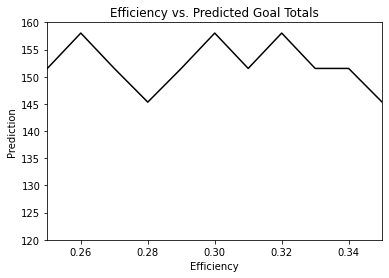

In [40]:
deepplot(index , 'eff' , 'Efficiency vs. Predicted Goal Totals')

#### Efficiency Share Summary 

- Predictions varied here with results diminishing after 34%
- We will stick with 30% here, it is an impressive goal for the team to reach, but attainable in theory

#### Manipulating Save %

In [41]:
lists = [
        [0.30, 0.44 , 0.90],
        [0.30, 0.45 , 0.90],
        [0.30, 0.46 , 0.90],
        [0.30, 0.47 , 0.90],
        [0.30, 0.48 , 0.90],
        [0.30, 0.49 , 0.90],
        [0.30, 0.50 , 0.90],
        [0.30, 0.51 , 0.90],
        [0.30, 0.52 , 0.90],
        [0.30, 0.53 , 0.90],
        [0.30, 0.54 , 0.90]]
index = pd.DataFrame(lists, columns = ['eff', 'sav' , 'fb'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Efficiency' , index['eff'][i] , 'Save %', index['sav'][i] , 'FB Goals' , index['fb'][i])
    result.append(w)

1/1 [==============================] - 0s 33ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 29ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 29ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [42]:
index['Prediction'] = result
index

,eff,sav,fb,Prediction
0,0.3,0.44,0.9,158.029770
1,0.3,0.45,0.9,153.124405
2,0.3,0.46,0.9,153.124405
3,0.3,0.47,0.9,151.305496
4,0.3,0.48,0.9,158.029770
5,0.3,0.49,0.9,158.029770
6,0.3,0.50,0.9,153.124405
7,0.3,0.51,0.9,151.305496
8,0.3,0.52,0.9,151.305496
9,0.3,0.53,0.9,158.029770


In [43]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Save %')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([140, 160])
    plt.xlim([x.min(),x.max()])

    plt.show()

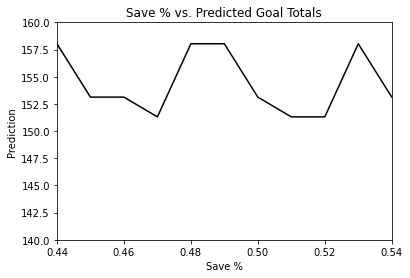

In [45]:
deepplot(index , 'sav' , 'Save % vs. Predicted Goal Totals')

#### Save % Summary

- Looking at the graph we see a lot of realistic upside between 48% and 50%
- we will choose the most attainable target in this instance that provides high upside according to the predictions.
- 49% going forward

#### Manipulating Fast Break Goals

In [46]:
lists = [
        [0.30, 0.49 , 0.90],
        [0.30, 0.49 , 0.95],
        [0.30, 0.49 , 1.00],
        [0.30, 0.49 , 1.25],
        [0.30, 0.49 , 1.50],
        [0.30, 0.49 , 1.60],
        [0.30, 0.49 , 1.70],
        [0.30, 0.49 , 1.80],
        [0.30, 0.49 , 1.90],
        [0.30, 0.49 , 2.00],
        [0.30, 0.49 , 2.20]]
index = pd.DataFrame(lists, columns = ['eff', 'sav' , 'fb'])

run = [0,1,2,3,4,5,6,7,8,9,10]

result = list()
for i in run:
    w = project(archers , 'Efficiency' , index['eff'][i] , 'Save %', index['sav'][i] , 'FB Goals' , index['fb'][i])
    result.append(w)

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 27ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new


1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new


1/1 [==============================] - 0s 30ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 25ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 29ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 30ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 28ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

1/1 [==============================] - 0s 28ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [47]:
index['Prediction'] = result
index

,eff,sav,fb,Prediction
0,0.3,0.49,0.90,158.029770
1,0.3,0.49,0.95,162.208099
2,0.3,0.49,1.00,158.029770
3,0.3,0.49,1.25,158.029770
4,0.3,0.49,1.50,158.029770
5,0.3,0.49,1.60,155.789185
6,0.3,0.49,1.70,158.029770
7,0.3,0.49,1.80,158.029770
8,0.3,0.49,1.90,162.208099
9,0.3,0.49,2.00,158.029770


In [50]:
def deepplot(index , x , title):
    
    fig, ax = plt.subplots()


    x = index[x]
    y = index['Prediction']

    ax.plot(x,y, c = 'black')


    ax.set_title(title)
    ax.set_xlabel('Fast Break Goals')
    ax.set_ylabel('Prediction')
    
    
    plt.ylim([150, 170])
    plt.xlim([x.min(),x.max()])

    plt.show()

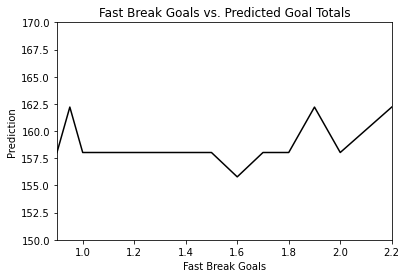

In [51]:
deepplot(index , 'fb' , 'Fast Break Goals vs. Predicted Goal Totals')

####  Fast Break Goals Summary
- Teams score a wide range of fast break goals depending on their playstyle, but overall good teams usually are able to capitalize on those opportunities
- This is a number you would also expect to see improve with an increased save %
- Teams had highs this year of up to 3 per game. 1.9 FB goals per game projected a strong improvement here, so we will use that going forward. It is an increase of nearly +1 fast break goal per game compared to what the redwoods actually did this year. 

#### Wrapping Up

In [53]:
redwoods = team2022[team2022['Team'] == 'Redwoods']
v2redwoods = projectfinal(redwoods ,
        'Efficiency' , .30 ,
        'Save %', .49 ,
        'FB Goals' , 1.9)

1/1 [==============================] - 0s 26ms/step


<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[metric] = new
<ipython-input-5-34d8a6aff0ab>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [54]:
print('Projected Goals per Game', v2redwoods['predictions'].mean())
print('Projected Total Goals' , v2redwoods['predictions'].sum())
print('Goals per Game',redwoods['Goals'].mean())
print('Total Goals',redwoods['Goals'].sum())
print('Goals per Game Delta', redwoods['Goals'].mean() - v2redwoods['predictions'].mean() )

Projected Goals per Game 13.169132232666016
Projected Total Goals 144.86046
Goals per Game 10.272727272727273
Total Goals 113
Goals per Game Delta -2.8964049599387423


In [55]:
team2022.groupby(['Team']).mean()[['Margin']]

,Margin
Team,
Archers,1.916667
Atlas,0.900000
Cannons,-2.700000
Chaos,-1.307692
Chrome,0.909091
Redwoods,-1.272727
Waterdogs,-0.250000
Whipsnakes,1.727273


#### Final Summary

Applying our updated stats to the redwoods 2022 season we were able to project them at just under +3 more goals per game. Their average margin was -1.2 , so it is not a stretch to say that +3 goals per game would have a drastic impact on their season win total and playoff chances. 

There is a lot of other factors in play, but it gives a good picture of how their poor save % and fast break goal performance especially brought them down this season. They only scored 113 goals all year, one of the lower team totals. They clearly were losing goals in the fast break portion of the field, so any improvement there will be important for them. Then being able to improve save % from worst in the league to somewhere near average will allow them to work through transition more as well as help improve their possession share. Improvements like this over the course of the year should translate into more goals for the redwoods overall, as shown by the model.

Points of focus for the Redwoods in 2023:
- Save % is a goalie stat, but also reflective of team defense. They need to focus on not allowing opponents to get off quality shots, this will help feed the next focus which is on fast break performance.
- Clearly with 4 wins on the year, the Redwoods found other ways to win games outside of fast break scoring, however championship teams are able to work well in this aspect of the game. Improving in this area will benefit the Redwoods greatly and inject some more goals into each game. 

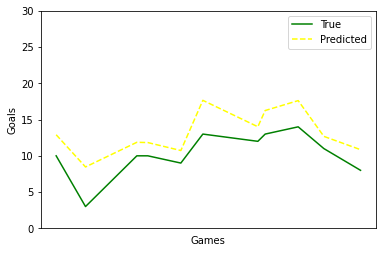

In [82]:
plotter(v2redwoods['predictions'] , redwoods['Goals'])